# Corona Virus Data Analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rawData = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv")

In [3]:
dataFrames = dict(states={}, counties={})
columns = ['cases', 'deaths']

def getTotal(): 
    if not "total" in dataFrames:
        dataFrames["total"] =rawData.groupby('date').sum()[columns]
    return dataFrames["total"]

def getState(state):
    if not state in dataFrames["states"]:
        statedf = rawData[rawData.state==state].groupby('date').sum()[columns]
        if statedf.empty:
            print (state + " is not in the data, did you spell it right? capitalization?")
            return 
        else:
            dataFrames["states"][state] = statedf
    return dataFrames["states"][state]

def getCounty(county):
    if not county in dataFrames["counties"]:
        countydf = rawData[rawData.county==county].groupby('date').sum()[columns]
        if countydf.empty:
            print(county + " is not in the data, did you spell it right? capitalization?")
            return
        else:
            dataFrames["counties"][county] = countydf
    return dataFrames["counties"][county]
        

In [4]:
getTotal().tail(2) # last two dates data to check how recent this data is


cases  deaths
date                      
2020-04-03  276091    7135
2020-04-04  310807    8505

In [5]:
def fitExponential(series):
    series = series.dropna()
    series = series[series>0]
    logseries = np.log(series)
    n = len(logseries)
    rate, intercept = np.polyfit(np.arange(n), logseries, 1) 
    base = np.exp(intercept)
    return (rate, base, n) 


In [6]:
def plotFitted(series, name, log=True): 
    (rate, base, n) = fitExponential(series)
    x = np.arange(n)
    series = series[-n:]
    if log:
        plt.semilogy()
    sbn.set(rc={'figure.figsize':(11.7,8.27)})
    sbn.scatterplot(x, series, label=f"{name} actual")
    sbn.lineplot(x, base * np.exp(rate*x) , label=f"{name} expected with constant exponential growth")
    plt.show()

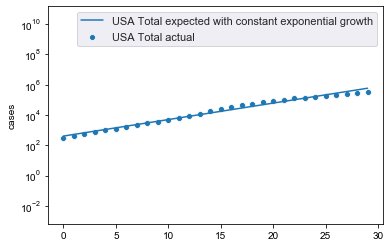

In [7]:
plotFitted(getTotal()["cases"][-30:], "USA Total")

In [8]:
def growthRateAnalysis(series, name, n=30):
    rate, base, n = fitExponential(series[-n:])
    name = f"{name} {series.name}"
    formula = f"{series.name} = {np.round(base, 2)} * exp({np.round(rate, 4)} * day)"
    dailyGrowth = np.round(100 * (np.exp(rate) - 1), 2)
    daysToDoubling = np.round(np.log(2)/rate, 2)
    print(f"{name} exponential formula fitted with {n} points:")
    print(formula)
    print(f"fitted daily growth rate: {dailyGrowth} %, fitted days to doubling: {daysToDoubling}")
    deltas = series.diff(1)
    rates = 100*deltas/series
    data = {
        f"{name} day to day growth rate (%)":rates, 
        f"{name} 3 day moving average":rates.rolling(window=3).mean(), 
        f"{name} 5 day moving average":rates.rolling(window=5).mean(), 
    }
    df = pd.DataFrame(data).dropna()[-n:]
    gr = df.tail(1)[f"{name} 5 day moving average"].values[0]
    dailyGrowth = np.round(gr, 2)
    daysToDoubling = np.round(np.log(2)*100/gr, 2)
    print(f"actual daily growth rate: {dailyGrowth} %, actual days to doubling: {daysToDoubling}")    
    sbn.lineplot(data=df)
    plt.show()
    plotFitted(series[-n:], name)


Total USA cases exponential formula fitted with 30 points:
cases = 402.92 * exp(0.251 * day)
fitted daily growth rate: 28.53 %, fitted days to doubling: 2.76
actual daily growth rate: 12.04 %, actual days to doubling: 5.76


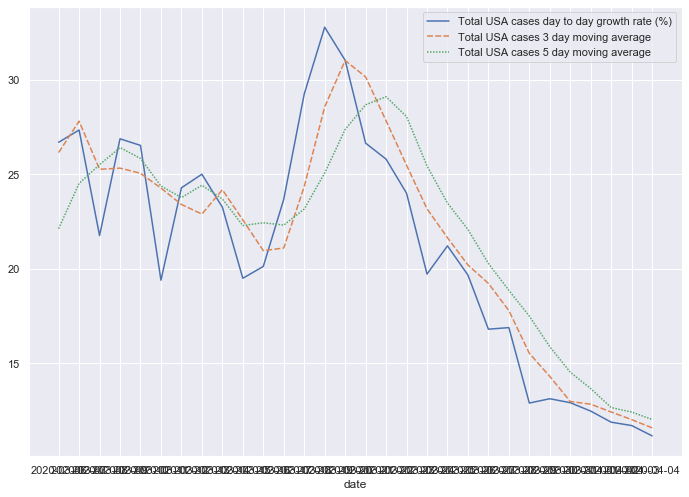

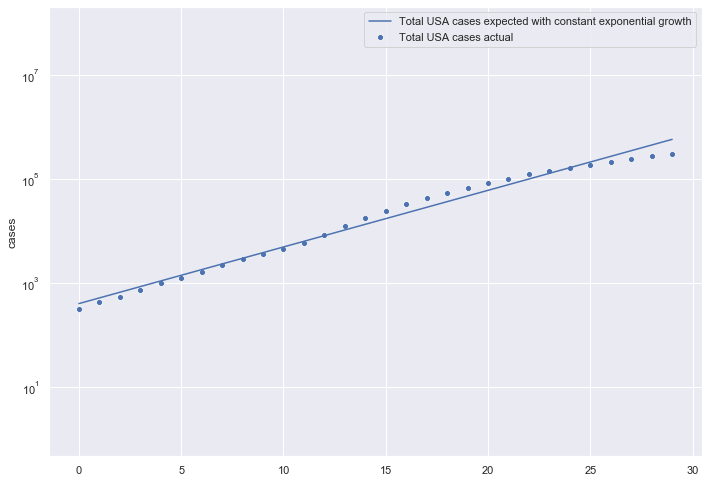

In [9]:
growthRateAnalysis(getTotal()['cases'], "Total USA")

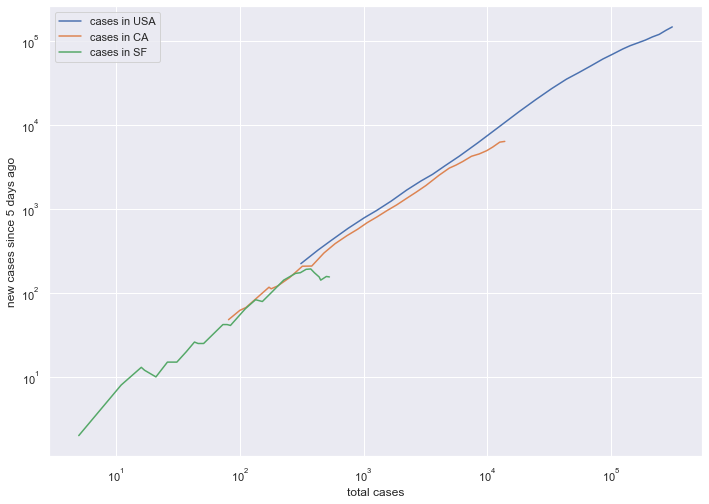

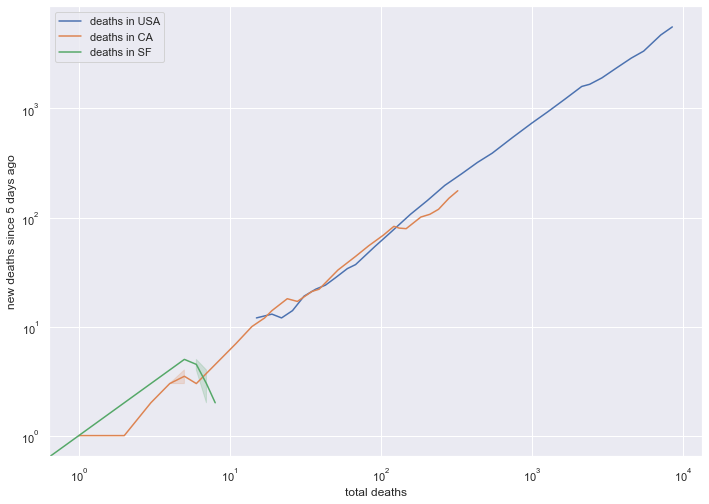

In [10]:
def trajectoryPlot(series, name):
    deltas = series.diff(5)
    fullname = f"{series.name} in {name}"
    x = f"total {series.name}"
    y = f"new {series.name} since 5 days ago"
    data = {x: series, y: deltas}
    plt.loglog()
    df = pd.DataFrame(data).dropna()[-30:]
    sbn.lineplot(x, y, data=df, label=fullname)
    
trajectoryPlot(getTotal()['cases'], "USA")
trajectoryPlot(getState("California")['cases'], "CA")
trajectoryPlot(getCounty("San Francisco")["cases"], "SF")
plt.show()
trajectoryPlot(getTotal()['deaths'], "USA")
trajectoryPlot(getState("California")['deaths'], "CA")
trajectoryPlot(getCounty("San Francisco")["deaths"], "SF")
plt.show()

In [11]:
def laggedPlot(df, name):
    vals = df.copy()
    vals = df.dropna()[df.cases > 0]
    # show correlation with wide range of time lags
    for i in range(30):
        vals[i] = df.cases.shift(i)
    vals = vals.drop(columns='cases')
    vals = vals[vals.deaths > 0][-20:]
    corrs = vals.corr()[['deaths']].drop('deaths')
    lc = np.log(vals).corr()[['deaths']].drop('deaths')
    lc[0] = lc.deaths
    for i in [3, 5, 7]:
        lc[i] = lc.deaths.rolling(i).mean()
    lc = lc.dropna()
    corrdata = {
        f"{name} correlation of log of deaths to log of cases by # of days ago": lc[0],
        f"{name} correlation 3 day moving average": lc[3],
        f"{name} correlation 5 day moving average": lc[5],
        f"{name} correlation 7 day moving average": lc[7],
    }
    corrsdf = pd.DataFrame(corrdata)
    print(f"Correlations for {name}:")
    sbn.lineplot(data=corrsdf)
    plt.show()
    # dig deeper into an interesting set of time lags
    values = vals[["deaths"]].copy()
    ratios = vals[["deaths"]].copy()
    interesting = [7, 14]
    for i in [0, 3, 5, 7]:
        l = lc[i].dropna()
        lmax = l[l==max(l)] # max at this correlation moving average
        interesting += list(lmax.index)
    for i in sorted(list(set(interesting))):
        values[f"{name} cases {i} days ago"] = vals[i]
        ratios[f"{name} deaths/cases {i} days ago"] = vals.deaths/vals[i]
    ratios = ratios.drop(columns=['deaths'])
    print(f"Deaths vs Lagged Values For {name}:")
    plt.semilogy()
    sbn.lineplot(data=values, dashes=False)
    plt.show()
    print(f"Deaths / Lagged Values For {name}:")
    plt.semilogy()
    sbn.lineplot(data=ratios, dashes=False)
    plt.show()

    

Correlations for USA:


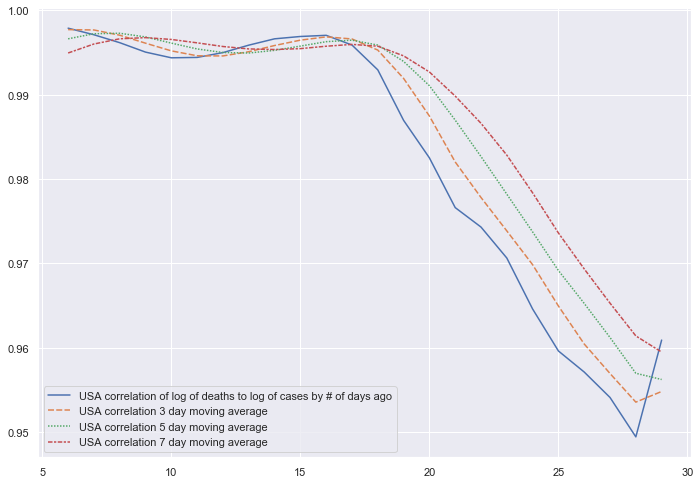

Deaths vs Lagged Values For USA:


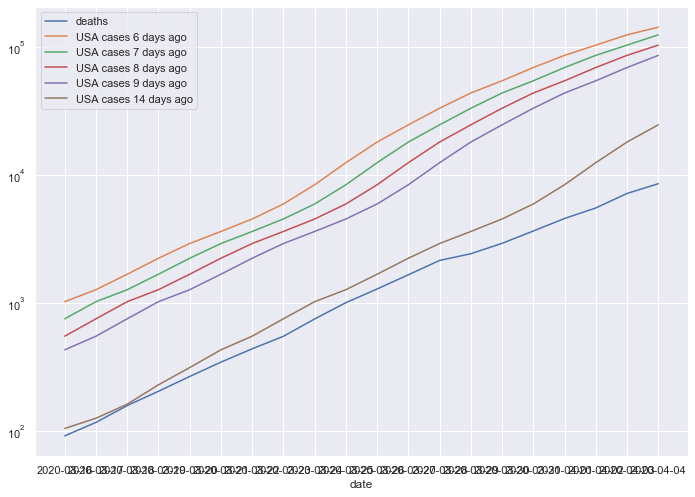

Deaths / Lagged Values For USA:


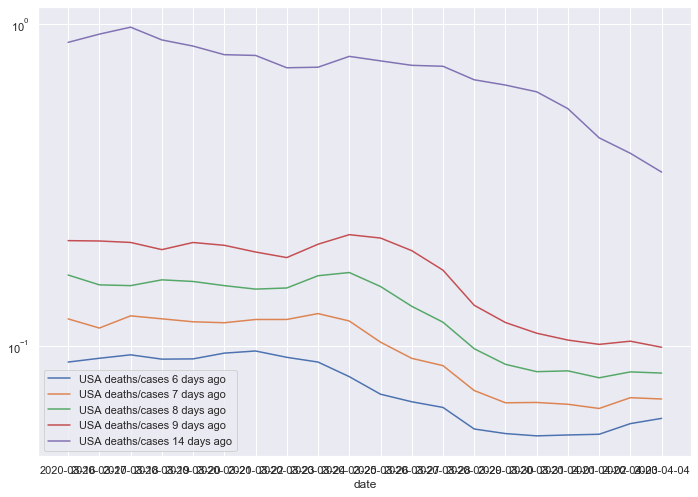

Correlations for CA:


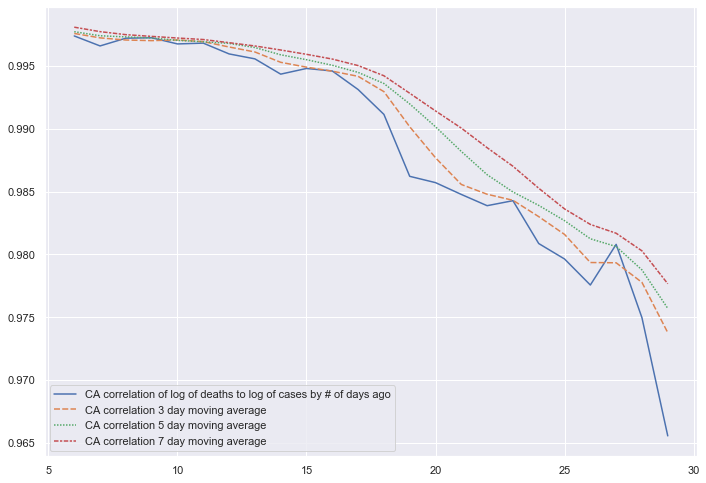

Deaths vs Lagged Values For CA:


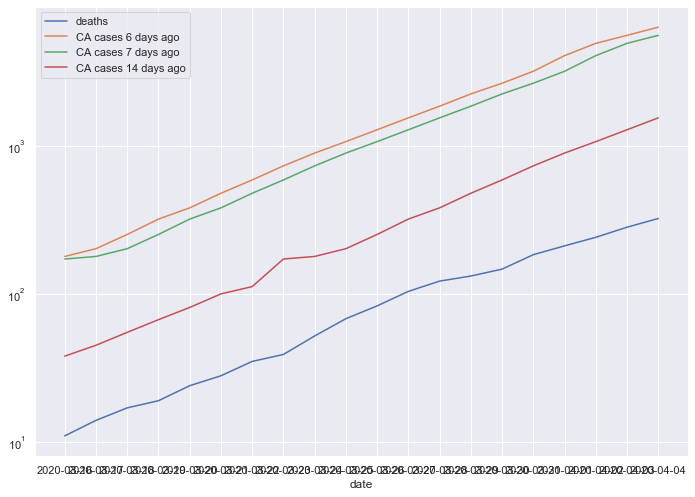

Deaths / Lagged Values For CA:


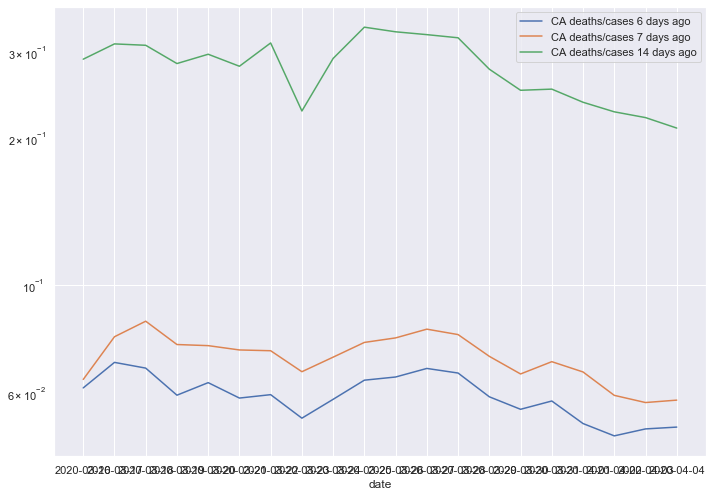

Correlations for SF:


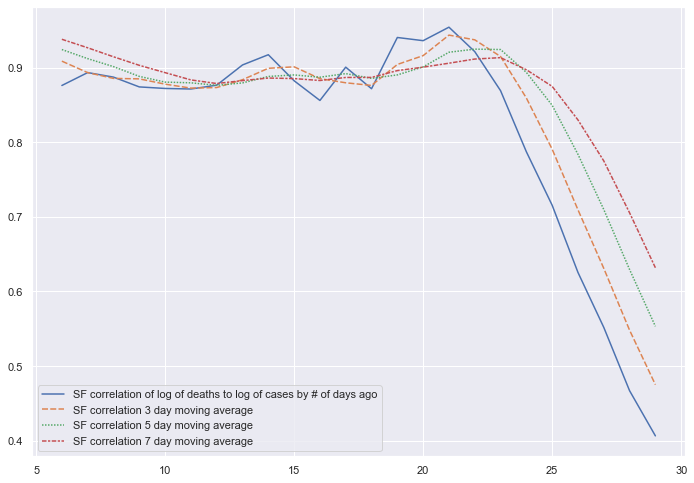

Deaths vs Lagged Values For SF:


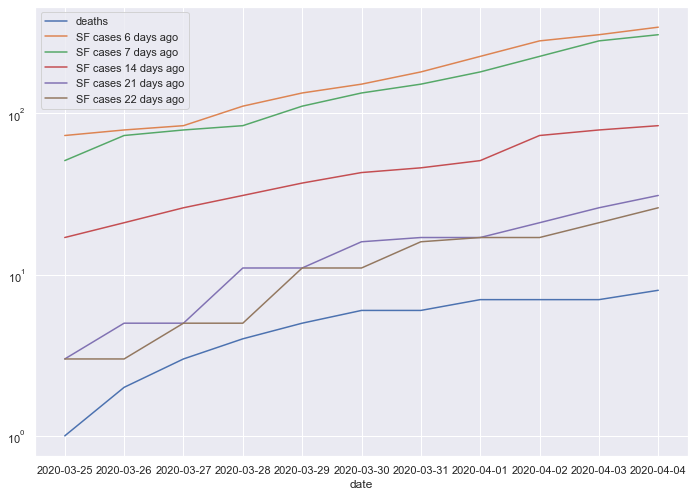

Deaths / Lagged Values For SF:


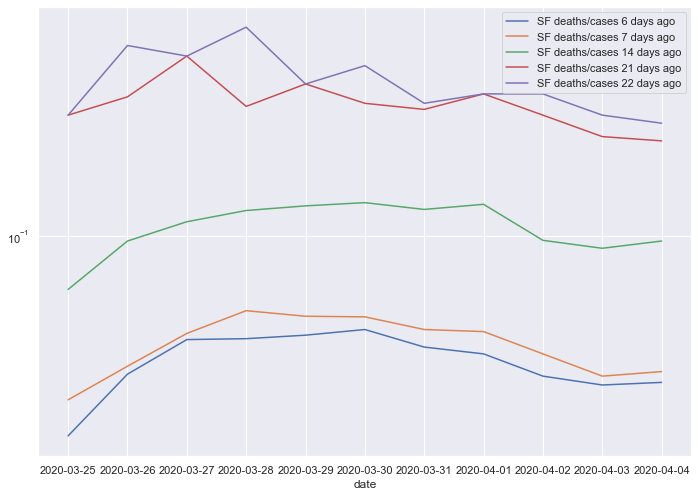

In [12]:
laggedPlot(getTotal(), "USA")
laggedPlot(getState("California"), "CA")
laggedPlot(getCounty("San Francisco"), "SF")

In [13]:
def analyse(counties=[], states=[], n=20):
    sbn.set(rc={'figure.figsize':(11.7,8.27)})
    names = counties + states + ["USA total:"]
    rates= []
    dfs = [getCounty(c) for c in counties] + [getState(s) for s in states] + [getTotal()] 
    print("Trajectory Plots to see if the curve is flattening:")
    for col in ["cases", "deaths"]:
        for df, name in zip(dfs, names):
            trajectoryPlot(df[col], name)
        plt.show()
    for df, name in zip(dfs, names):
        print(f"\n### Analysis for {name:} ###\n")
        growthRateAnalysis(df["cases"], name)
        growthRateAnalysis(df["deaths"], name)
        print(f"Trajectory plots for {name}, to see when the curve starts flattening")
        trajectoryPlot(df.cases, name)
        trajectoryPlot(df.deaths, name)
        plt.show()
        laggedPlot(df, name)


        
    
    

Trajectory Plots to see if the curve is flattening:


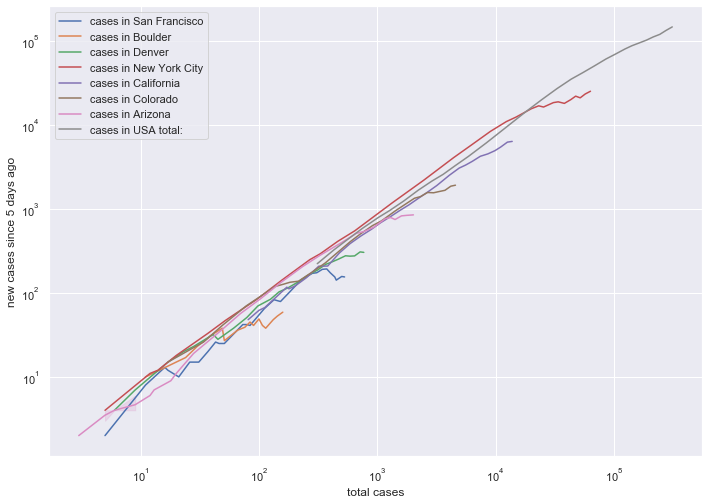

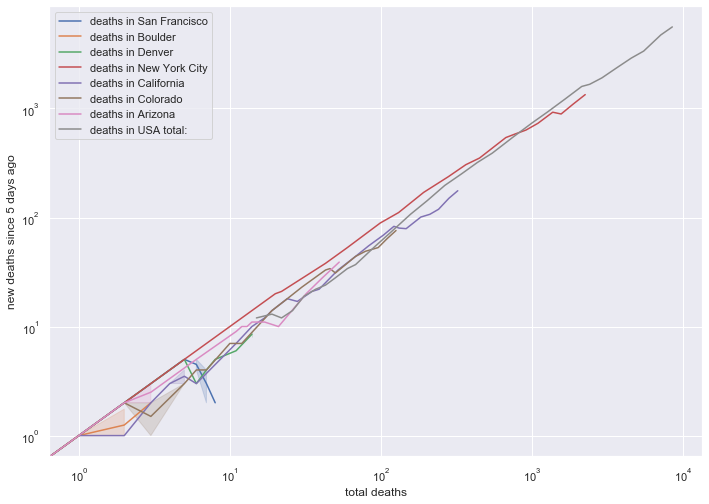


### Analysis for San Francisco ###

San Francisco cases exponential formula fitted with 30 points:
cases = 8.67 * exp(0.1541 * day)
fitted daily growth rate: 16.66 %, fitted days to doubling: 4.5
actual daily growth rate: 6.67 %, actual days to doubling: 10.4


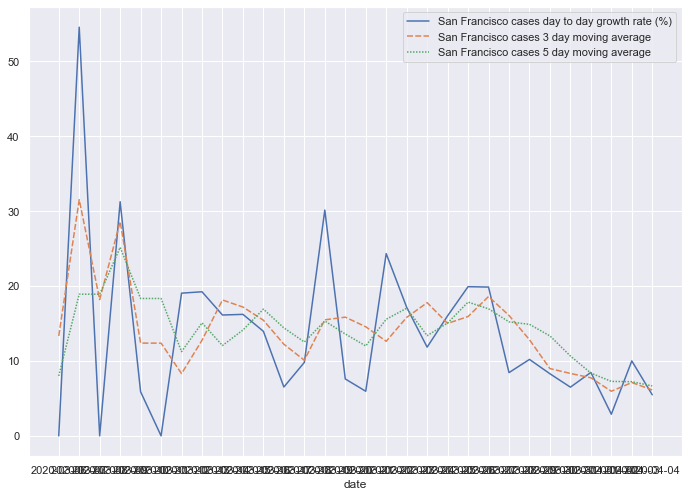

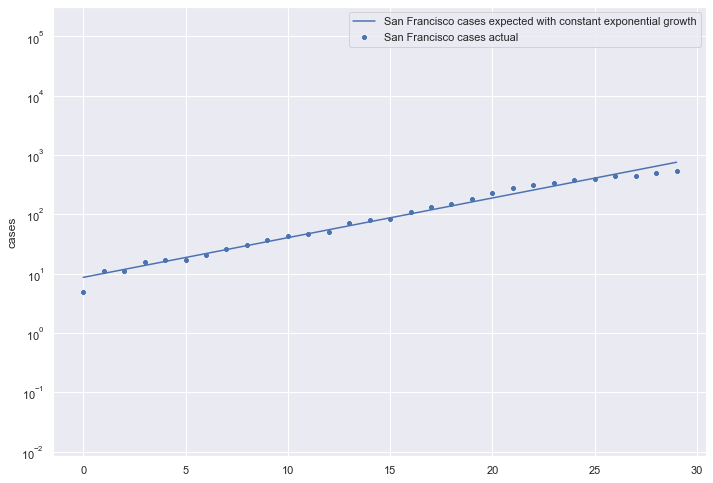

San Francisco deaths exponential formula fitted with 11 points:
deaths = 1.83 * exp(0.175 * day)
fitted daily growth rate: 19.13 %, fitted days to doubling: 3.96
actual daily growth rate: 5.36 %, actual days to doubling: 12.94


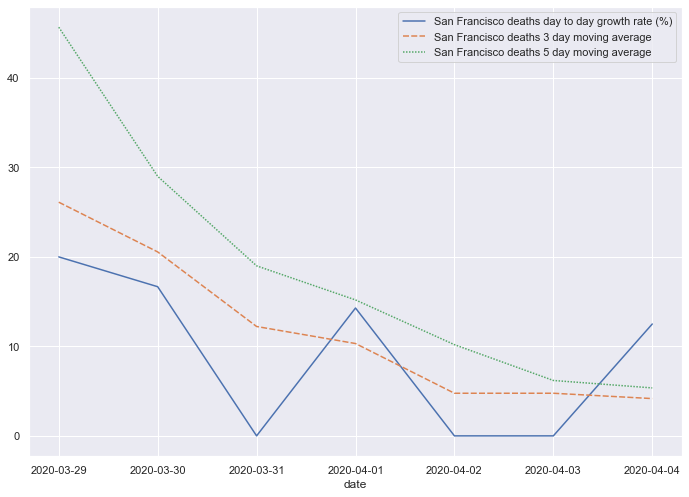

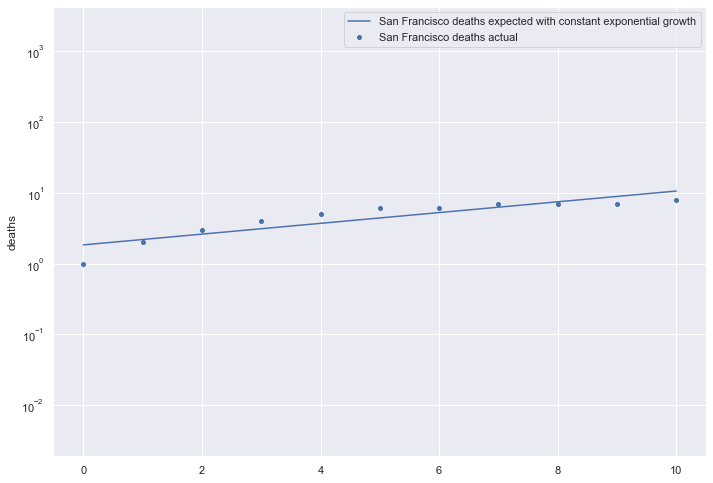

Trajectory plots for San Francisco, to see when the curve starts flattening


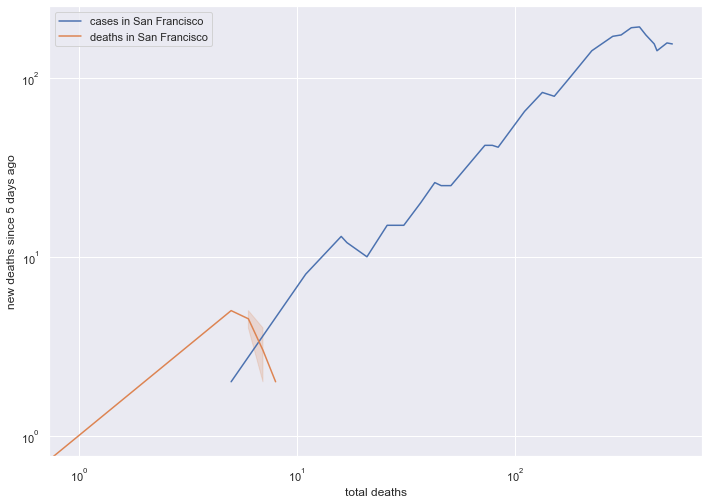

Correlations for San Francisco:


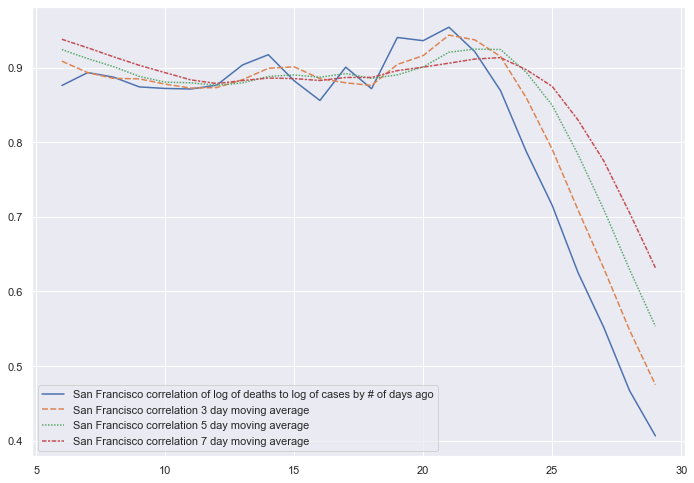

Deaths vs Lagged Values For San Francisco:


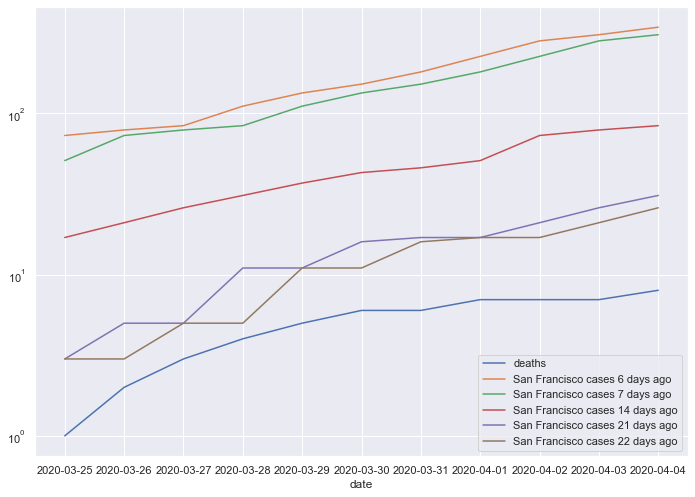

Deaths / Lagged Values For San Francisco:


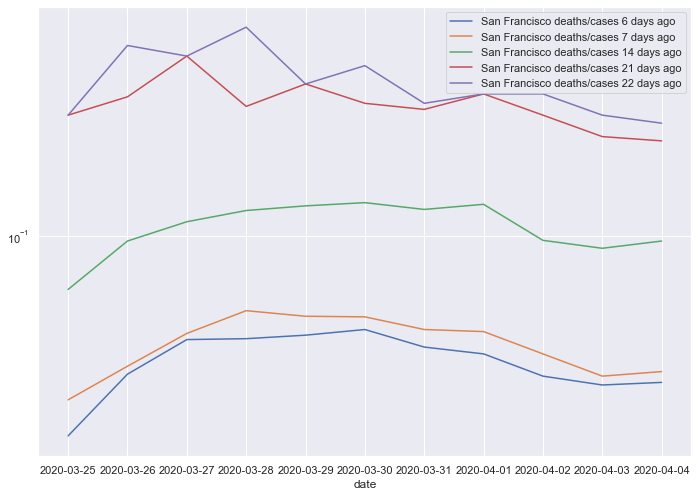


### Analysis for Boulder ###

Boulder cases exponential formula fitted with 22 points:
cases = 4.84 * exp(0.1896 * day)
fitted daily growth rate: 20.88 %, fitted days to doubling: 3.65
actual daily growth rate: 8.81 %, actual days to doubling: 7.86


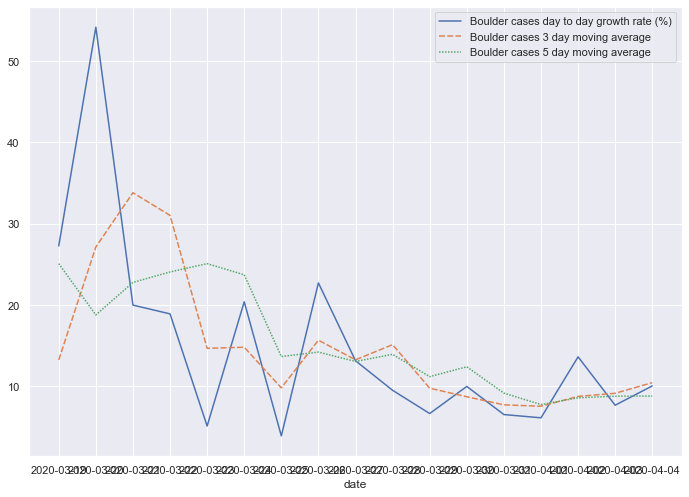

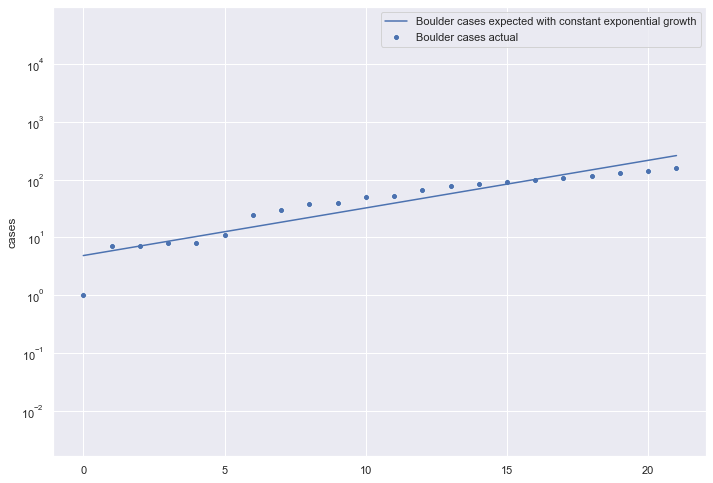

Boulder deaths exponential formula fitted with 9 points:
deaths = 0.87 * exp(0.1426 * day)
fitted daily growth rate: 15.32 %, fitted days to doubling: 4.86
actual daily growth rate: 16.67 %, actual days to doubling: 4.16


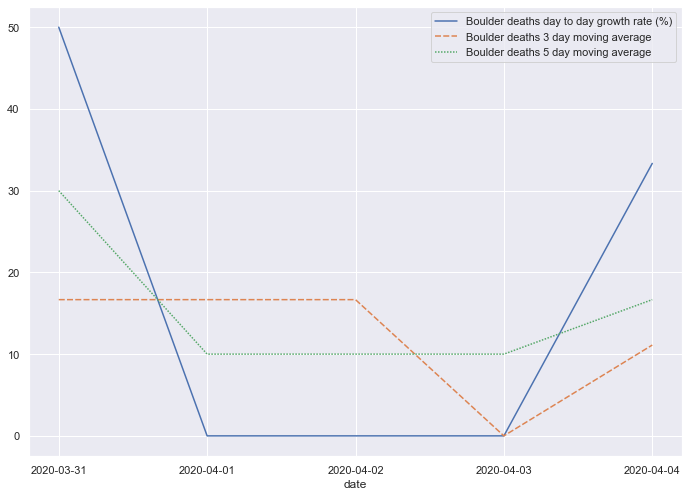

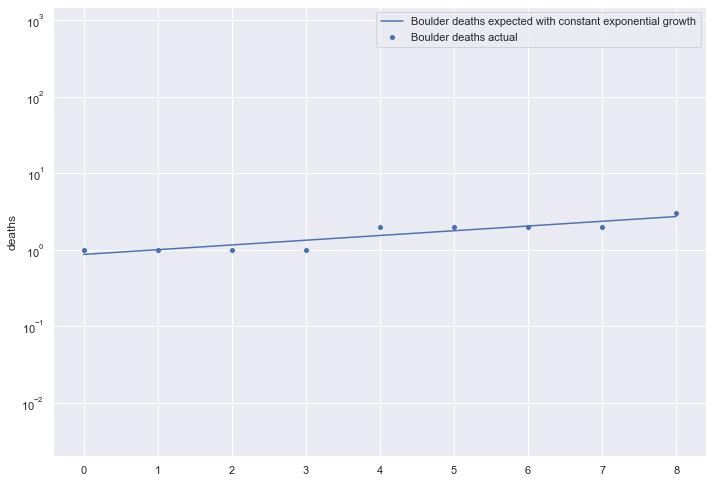

Trajectory plots for Boulder, to see when the curve starts flattening


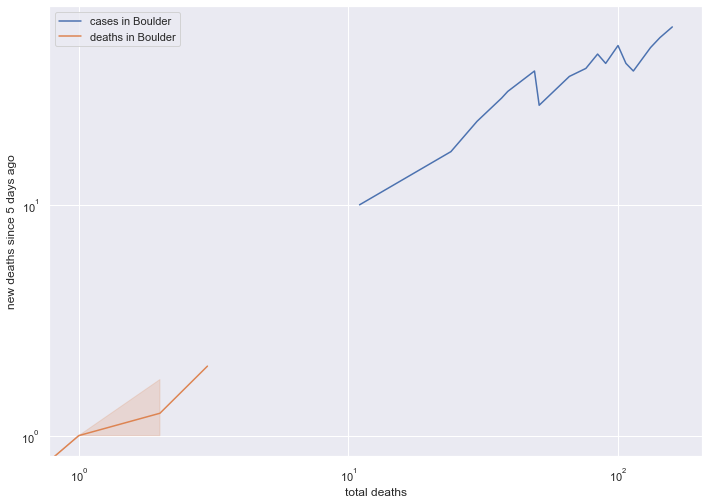

Correlations for Boulder:


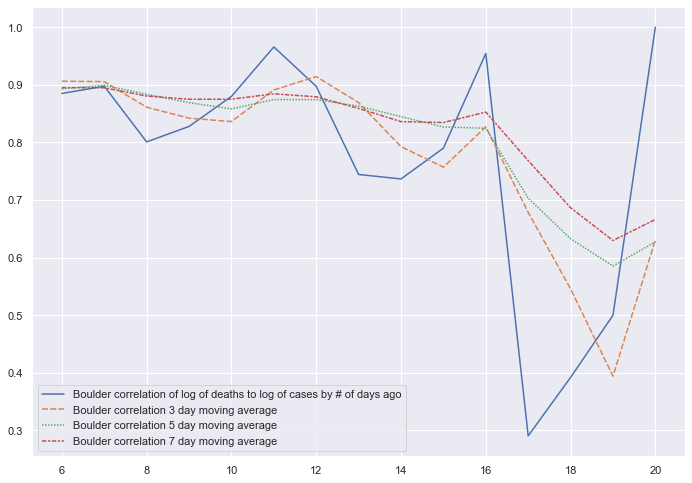

Deaths vs Lagged Values For Boulder:


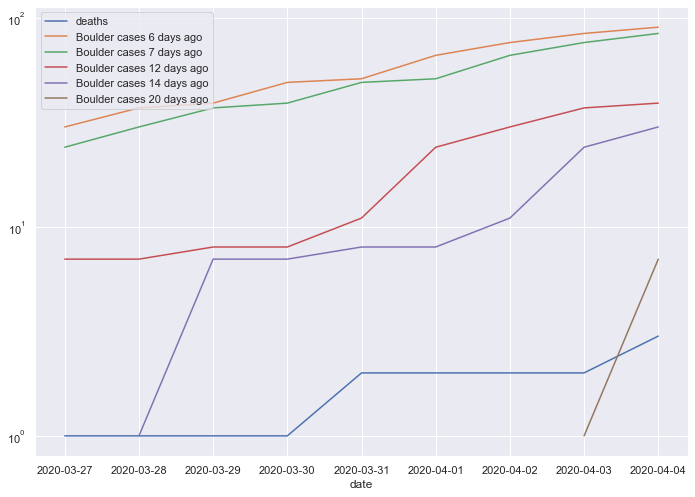

Deaths / Lagged Values For Boulder:


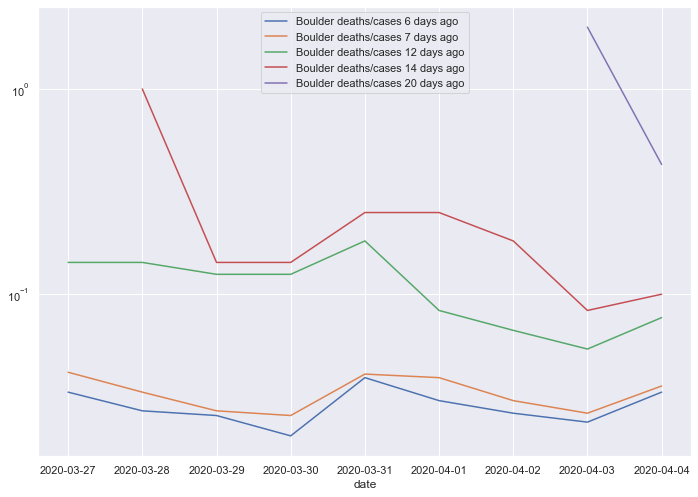


### Analysis for Denver ###

Denver cases exponential formula fitted with 30 points:
cases = 2.56 * exp(0.22 * day)
fitted daily growth rate: 24.61 %, fitted days to doubling: 3.15
actual daily growth rate: 9.54 %, actual days to doubling: 7.27


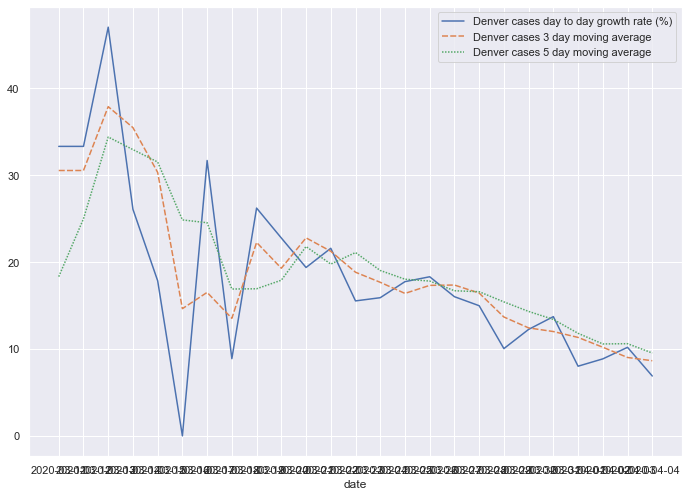

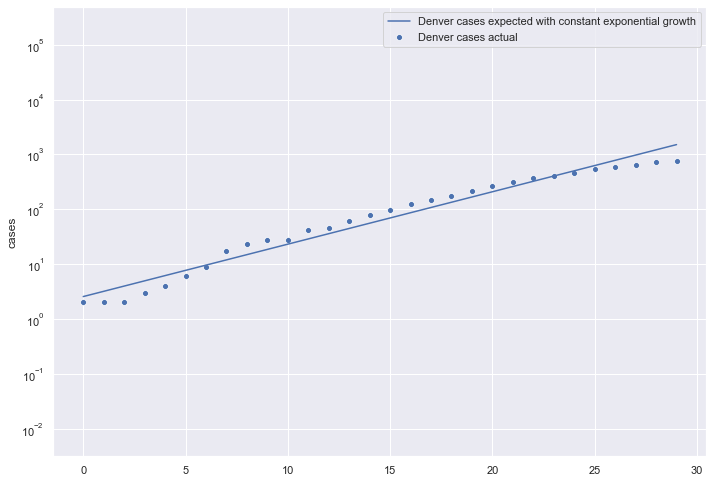

Denver deaths exponential formula fitted with 11 points:
deaths = 2.59 * exp(0.1731 * day)
fitted daily growth rate: 18.9 %, fitted days to doubling: 4.0
actual daily growth rate: 15.1 %, actual days to doubling: 4.59


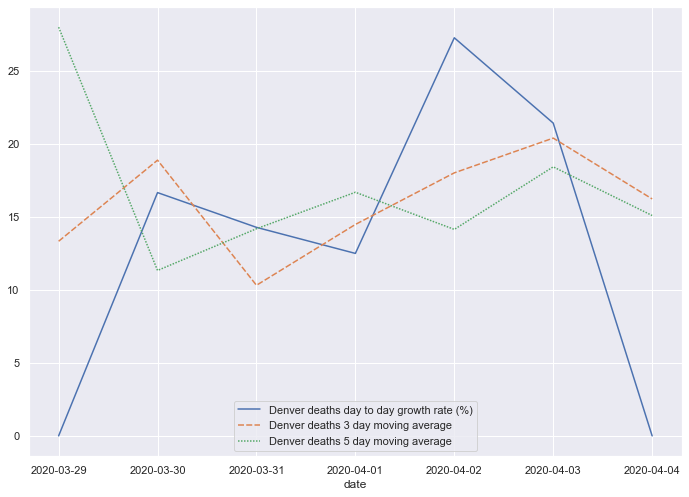

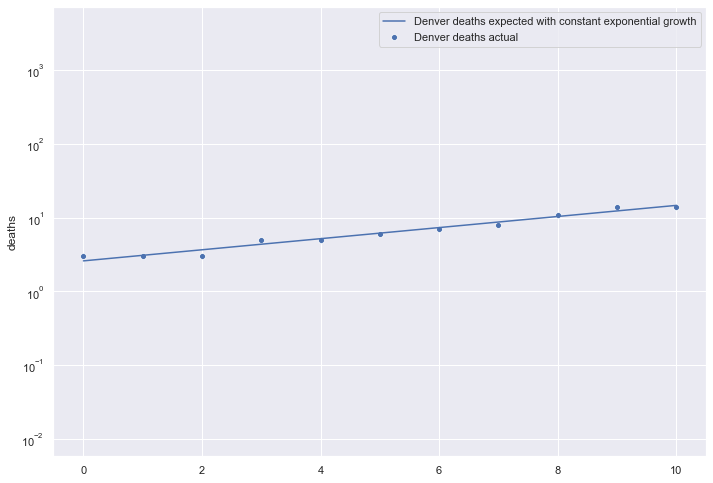

Trajectory plots for Denver, to see when the curve starts flattening


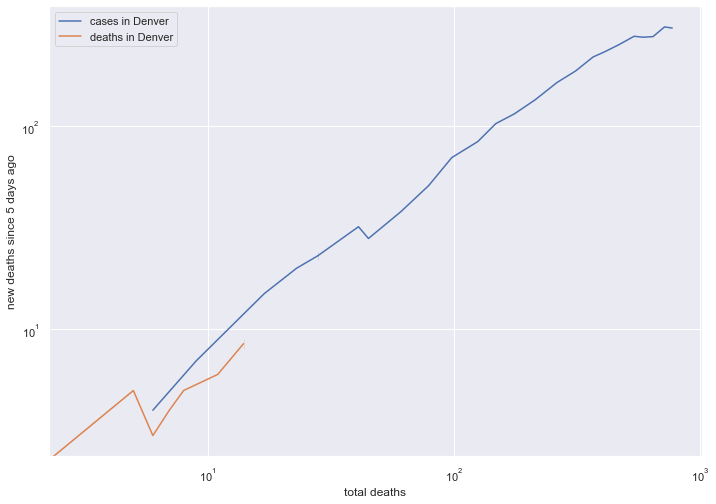

Correlations for Denver:


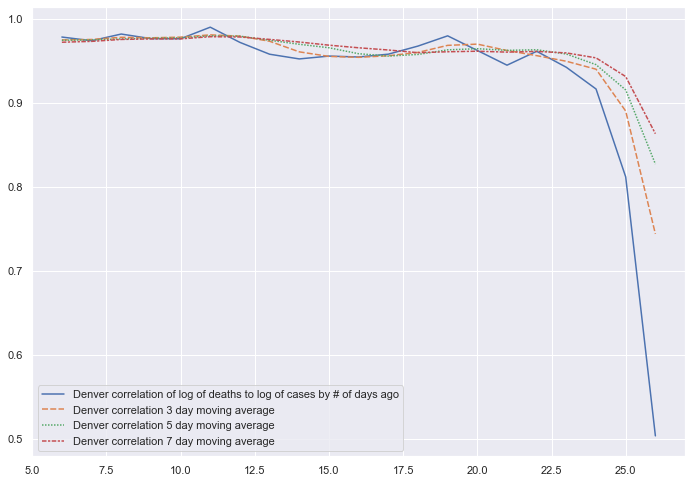

Deaths vs Lagged Values For Denver:


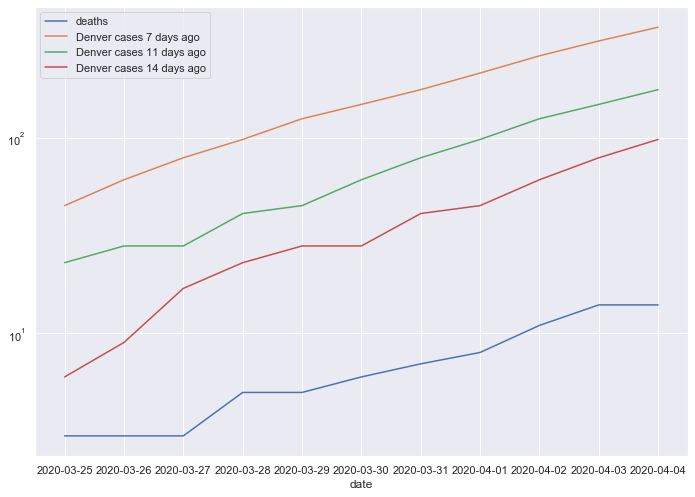

Deaths / Lagged Values For Denver:


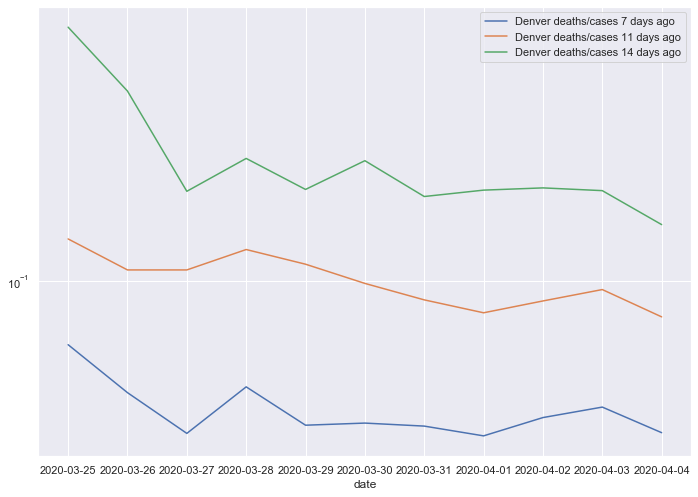


### Analysis for New York City ###

New York City cases exponential formula fitted with 30 points:
cases = 14.45 * exp(0.3374 * day)
fitted daily growth rate: 40.12 %, fitted days to doubling: 2.05
actual daily growth rate: 9.66 %, actual days to doubling: 7.18


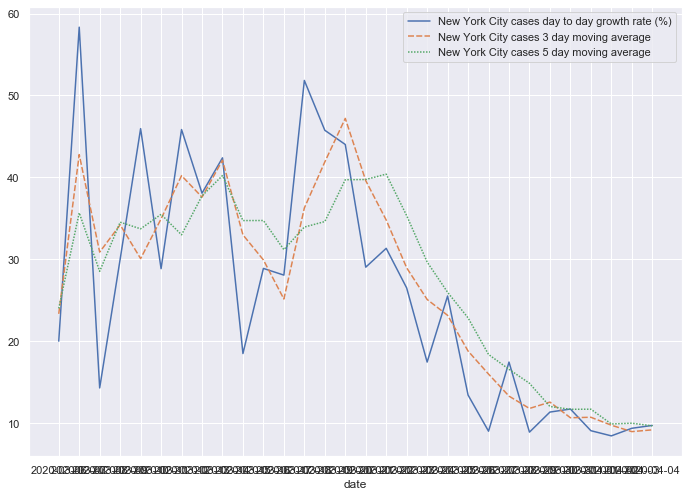

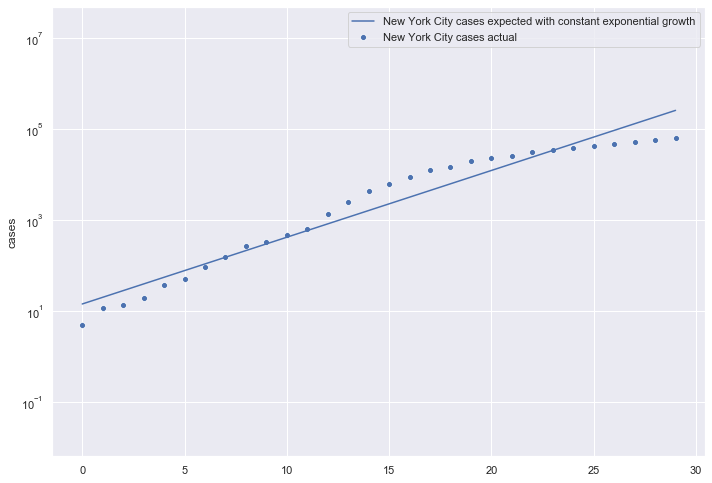

New York City deaths exponential formula fitted with 22 points:
deaths = 4.35 * exp(0.3317 * day)
fitted daily growth rate: 39.33 %, fitted days to doubling: 2.09
actual daily growth rate: 16.48 %, actual days to doubling: 4.21


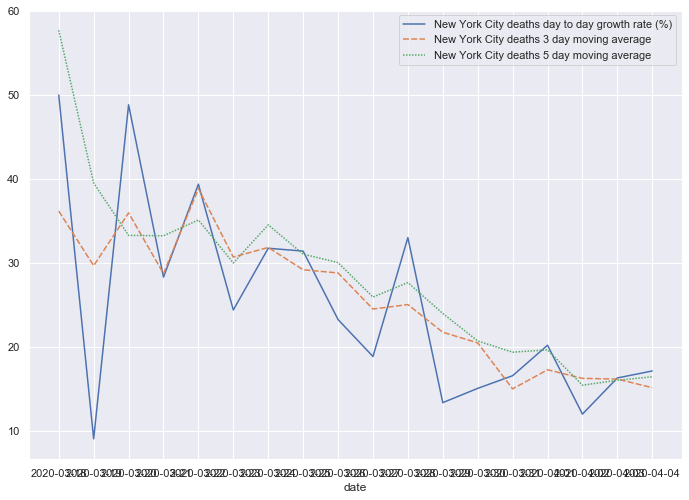

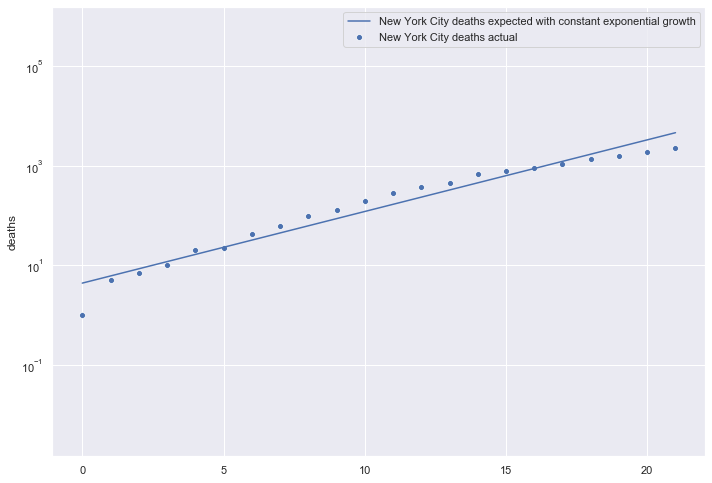

Trajectory plots for New York City, to see when the curve starts flattening


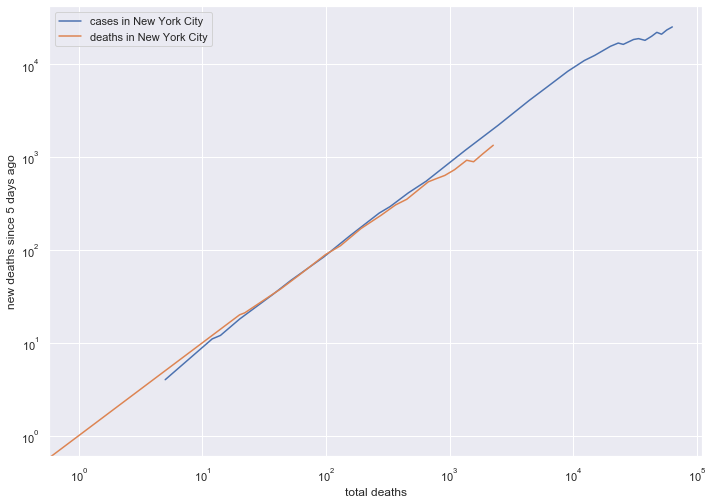

Correlations for New York City:


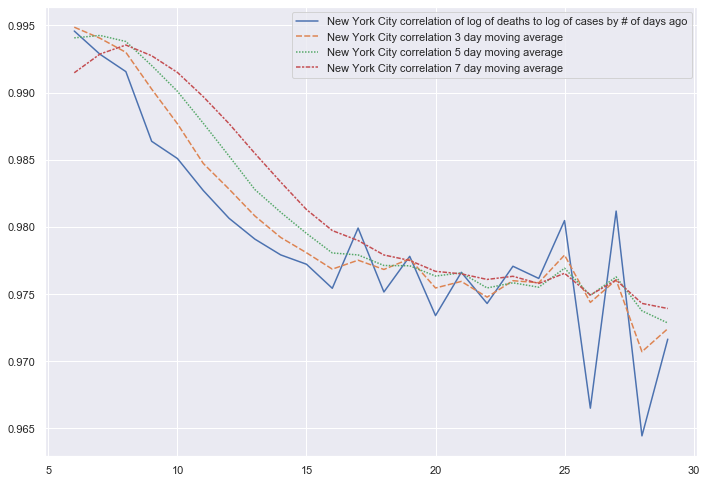

Deaths vs Lagged Values For New York City:


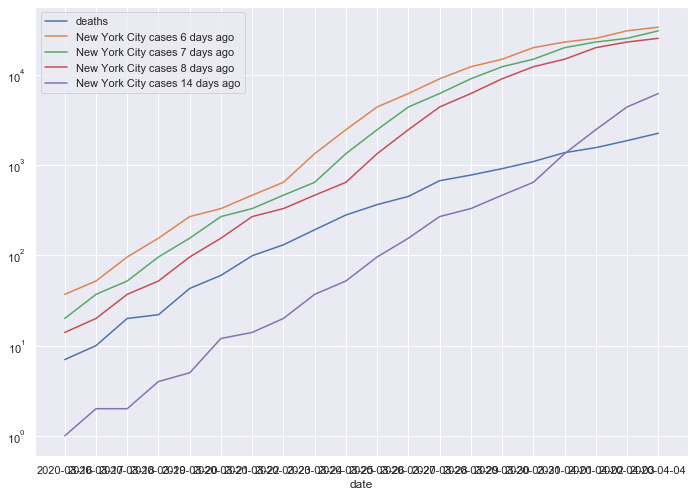

Deaths / Lagged Values For New York City:


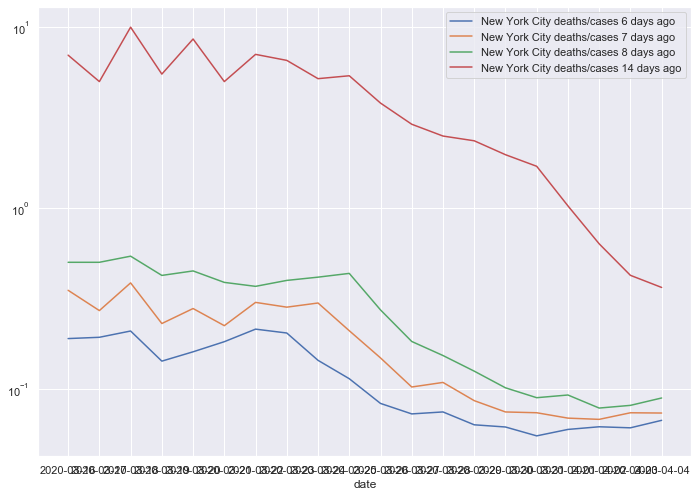


### Analysis for California ###

California cases exponential formula fitted with 30 points:
cases = 90.81 * exp(0.1829 * day)
fitted daily growth rate: 20.07 %, fitted days to doubling: 3.79
actual daily growth rate: 11.64 %, actual days to doubling: 5.95


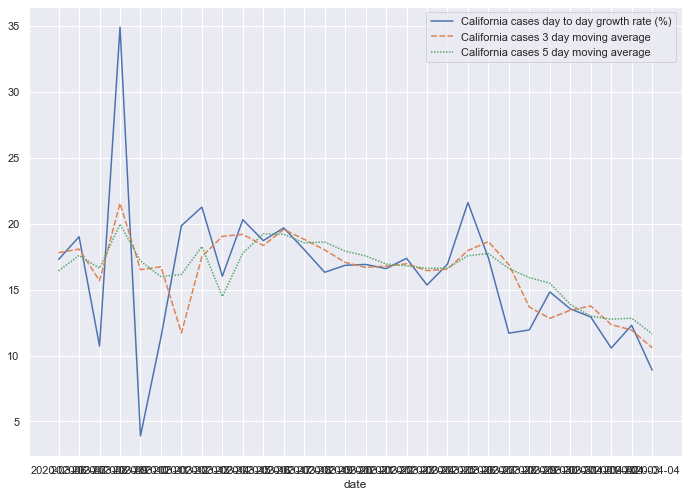

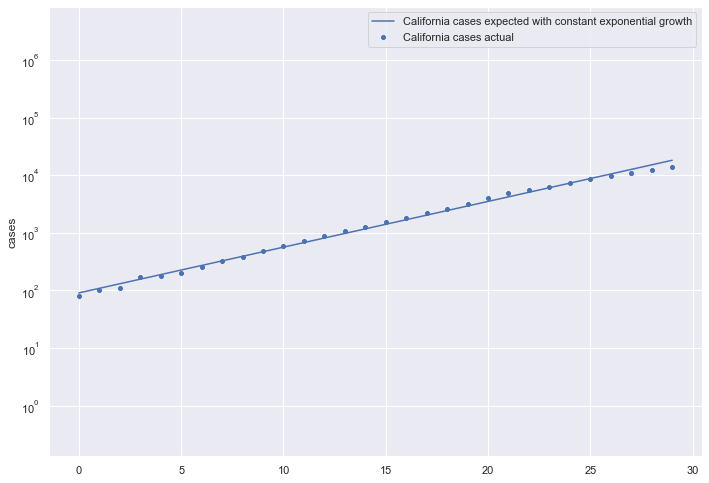

California deaths exponential formula fitted with 30 points:
deaths = 1.14 * exp(0.2061 * day)
fitted daily growth rate: 22.89 %, fitted days to doubling: 3.36
actual daily growth rate: 14.52 %, actual days to doubling: 4.77


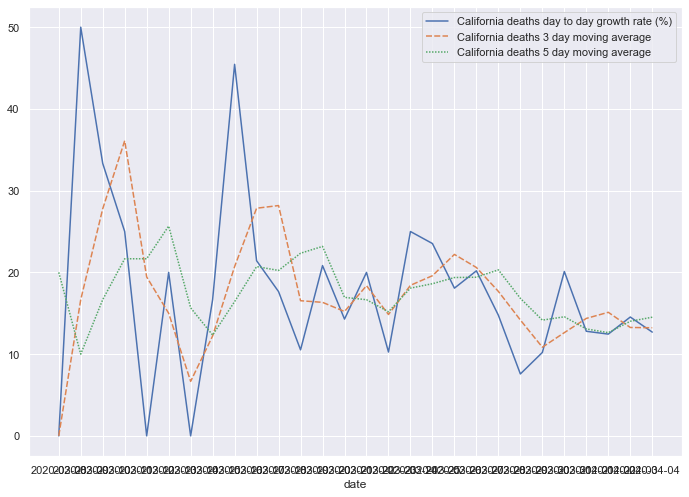

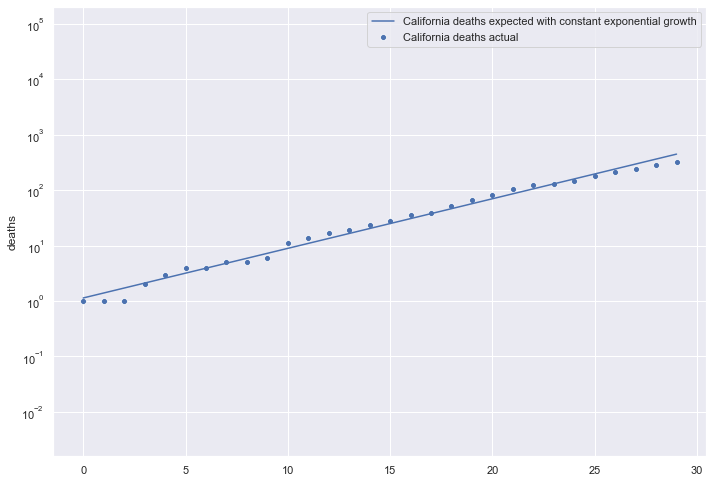

Trajectory plots for California, to see when the curve starts flattening


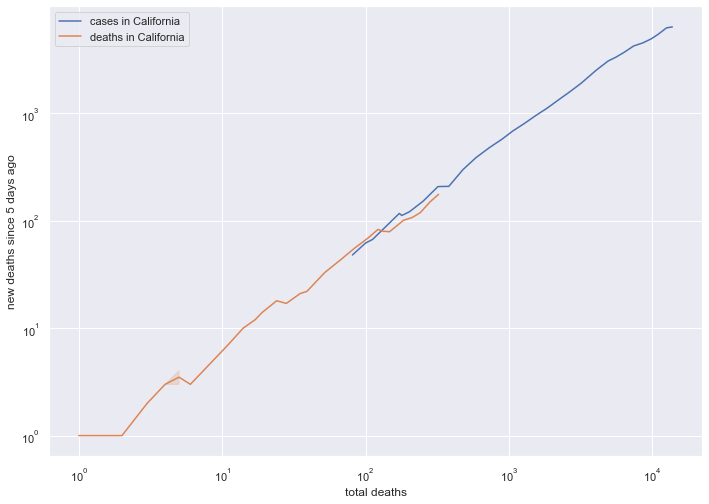

Correlations for California:


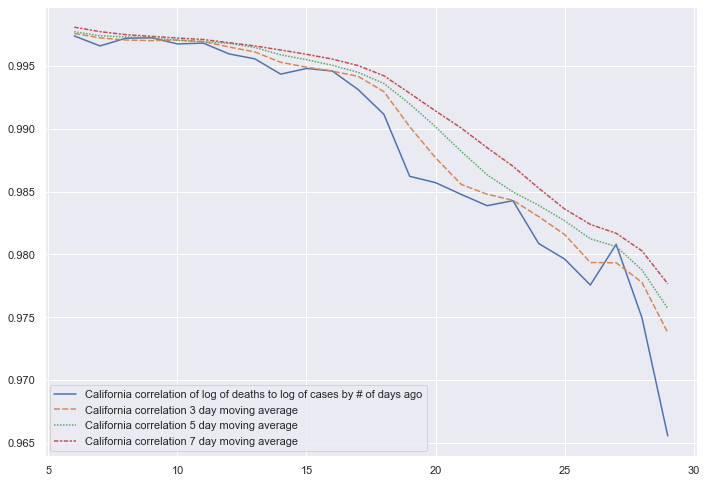

Deaths vs Lagged Values For California:


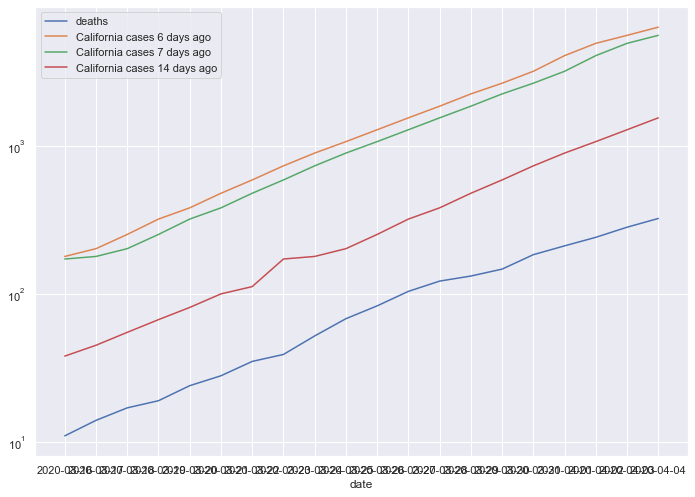

Deaths / Lagged Values For California:


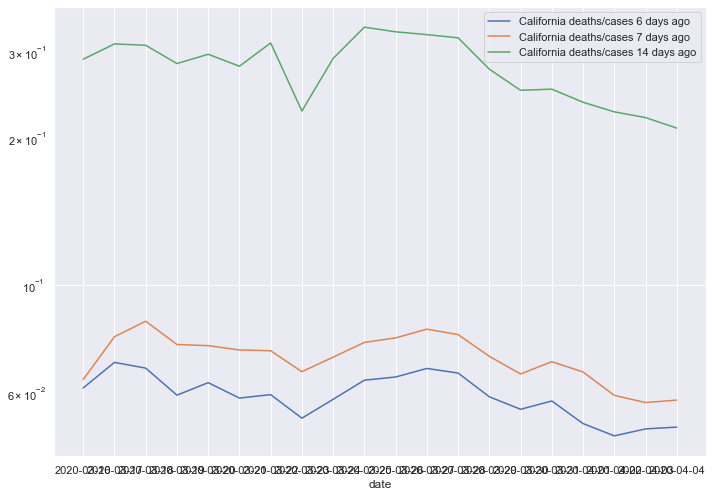


### Analysis for Colorado ###

Colorado cases exponential formula fitted with 30 points:
cases = 10.76 * exp(0.2318 * day)
fitted daily growth rate: 26.09 %, fitted days to doubling: 2.99
actual daily growth rate: 10.3 %, actual days to doubling: 6.73


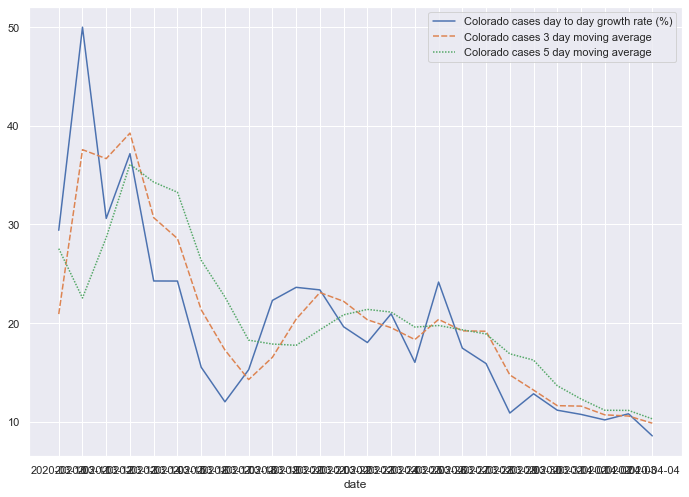

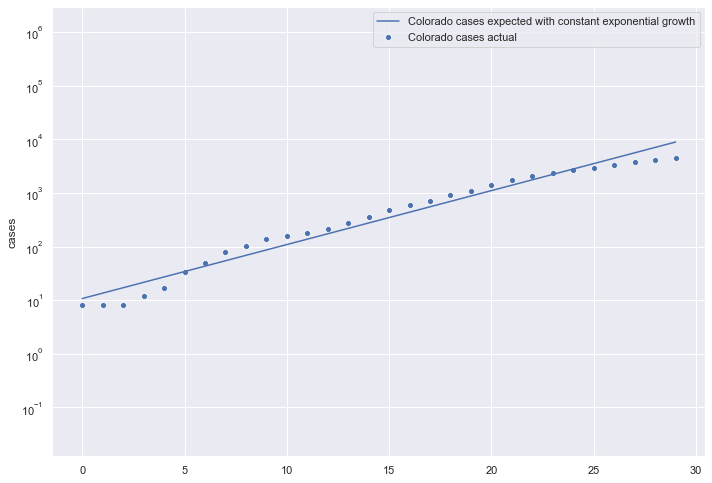

Colorado deaths exponential formula fitted with 24 points:
deaths = 1.05 * exp(0.2143 * day)
fitted daily growth rate: 23.9 %, fitted days to doubling: 3.23
actual daily growth rate: 16.71 %, actual days to doubling: 4.15


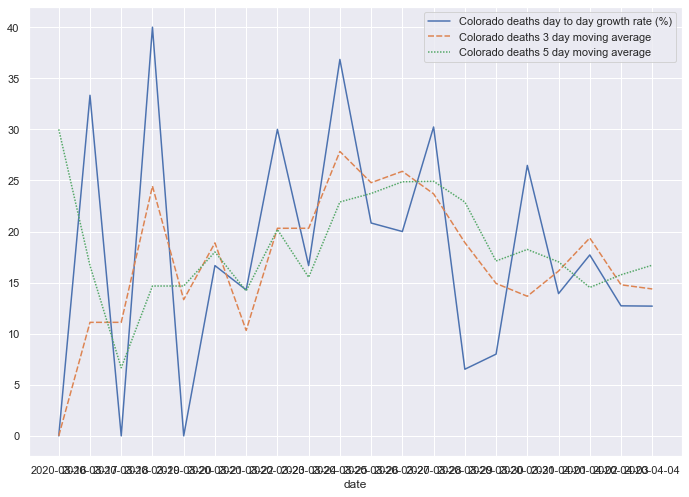

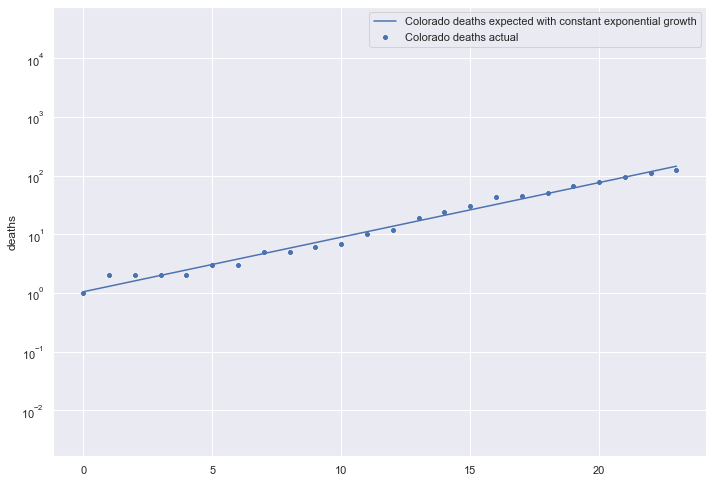

Trajectory plots for Colorado, to see when the curve starts flattening


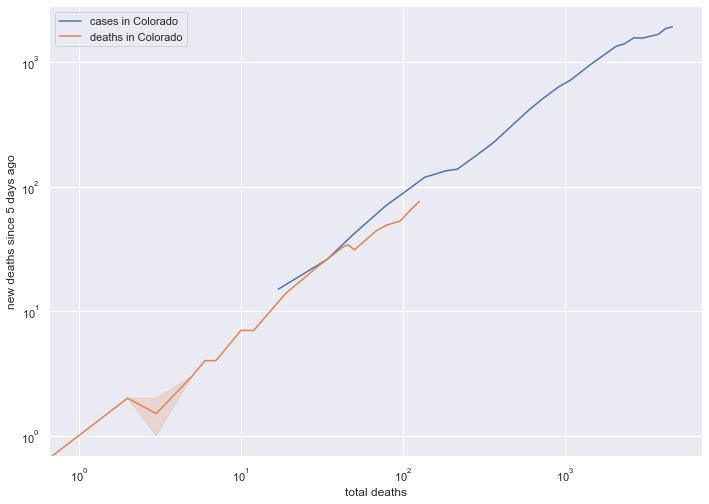

Correlations for Colorado:


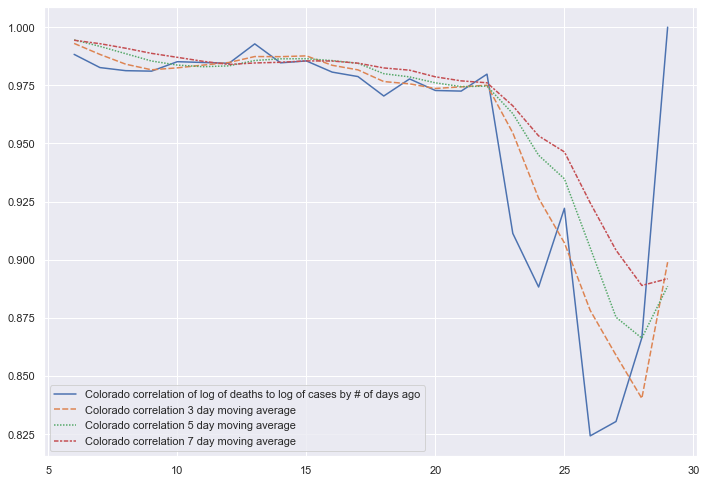

Deaths vs Lagged Values For Colorado:


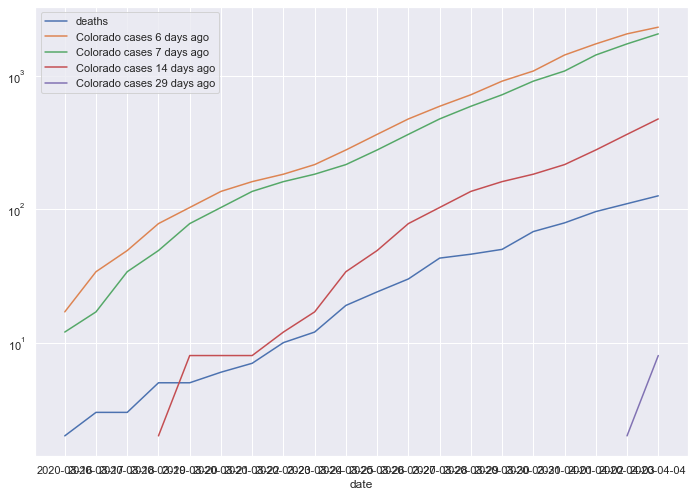

Deaths / Lagged Values For Colorado:


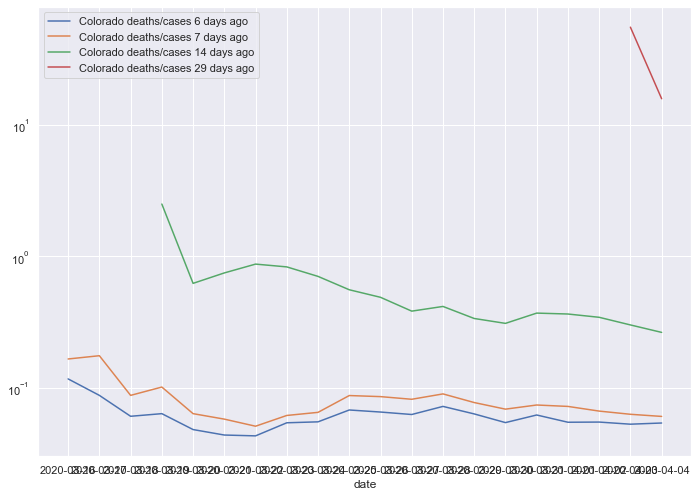


### Analysis for Arizona ###

Arizona cases exponential formula fitted with 30 points:
cases = 2.32 * exp(0.2498 * day)
fitted daily growth rate: 28.37 %, fitted days to doubling: 2.78
actual daily growth rate: 10.34 %, actual days to doubling: 6.7


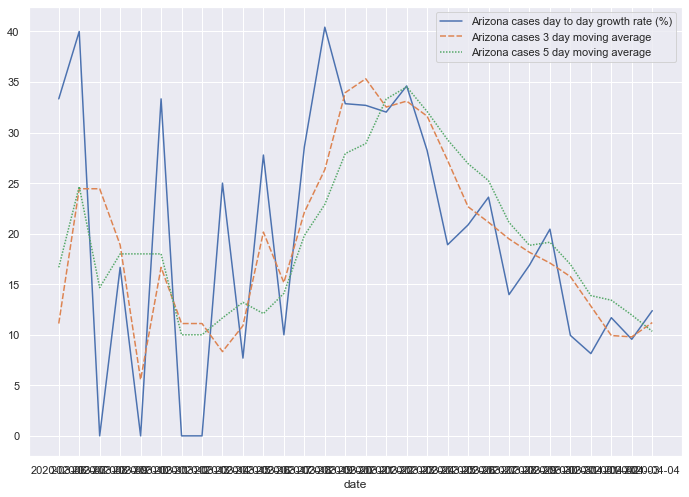

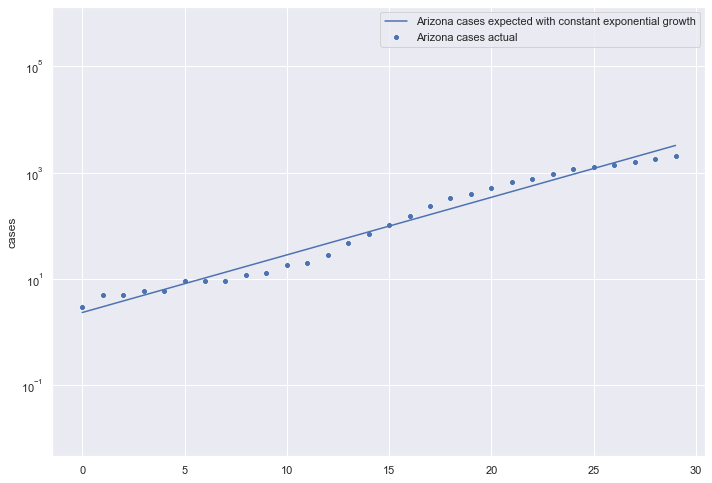

Arizona deaths exponential formula fitted with 16 points:
deaths = 1.03 * exp(0.2673 * day)
fitted daily growth rate: 30.64 %, fitted days to doubling: 2.59
actual daily growth rate: 23.13 %, actual days to doubling: 3.0


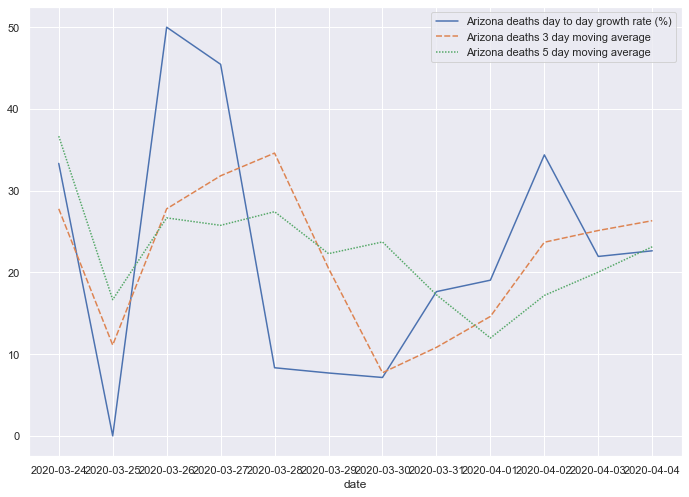

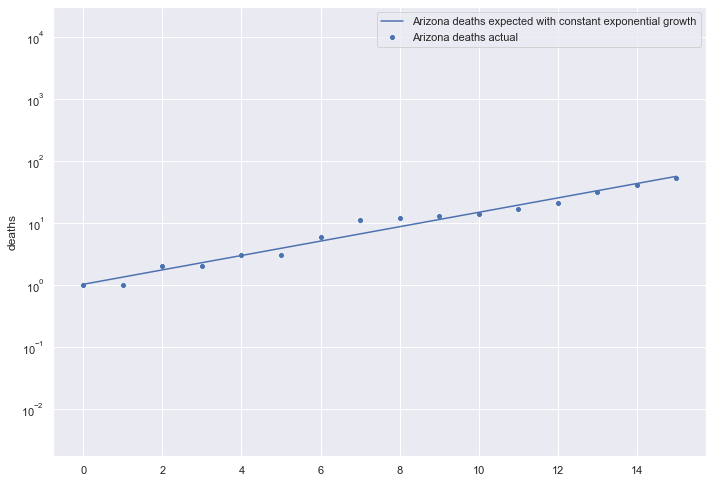

Trajectory plots for Arizona, to see when the curve starts flattening


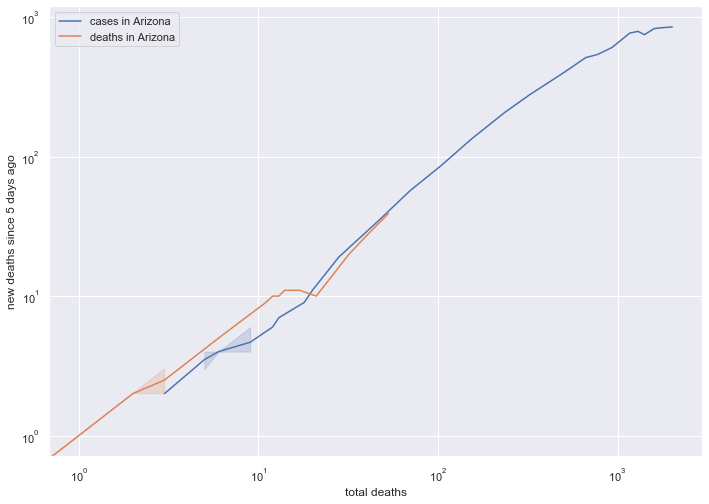

Correlations for Arizona:


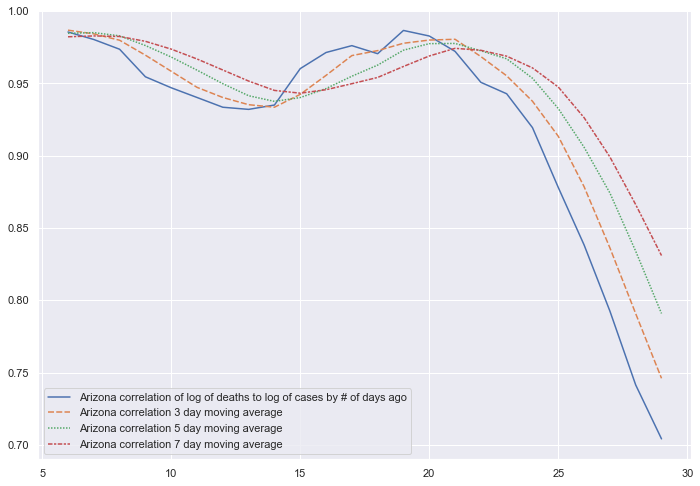

Deaths vs Lagged Values For Arizona:


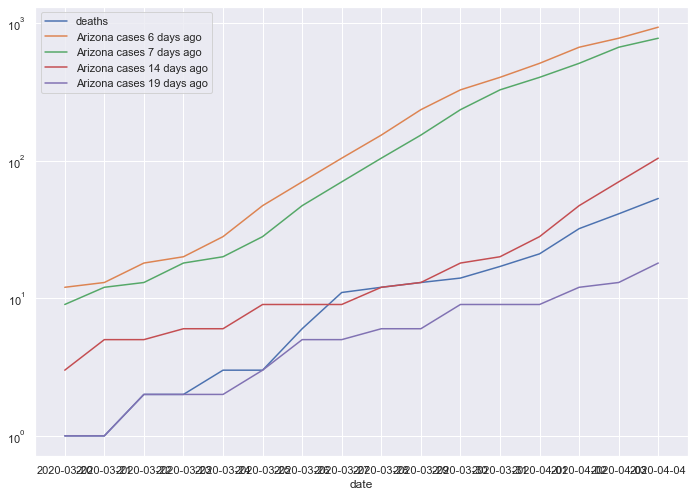

Deaths / Lagged Values For Arizona:


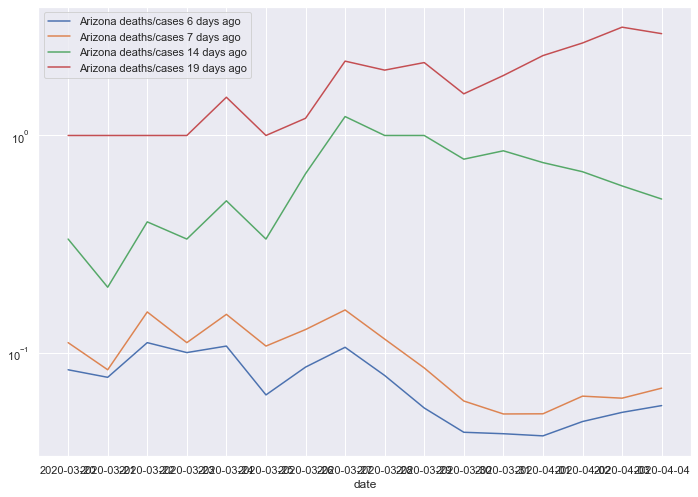


### Analysis for USA total: ###

USA total: cases exponential formula fitted with 30 points:
cases = 402.92 * exp(0.251 * day)
fitted daily growth rate: 28.53 %, fitted days to doubling: 2.76
actual daily growth rate: 12.04 %, actual days to doubling: 5.76


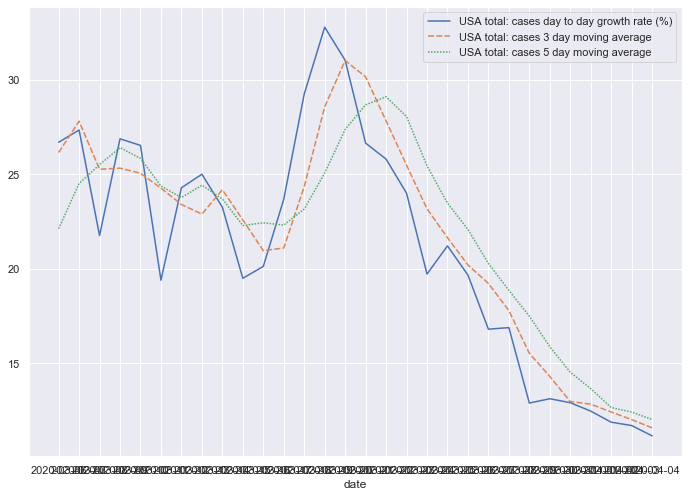

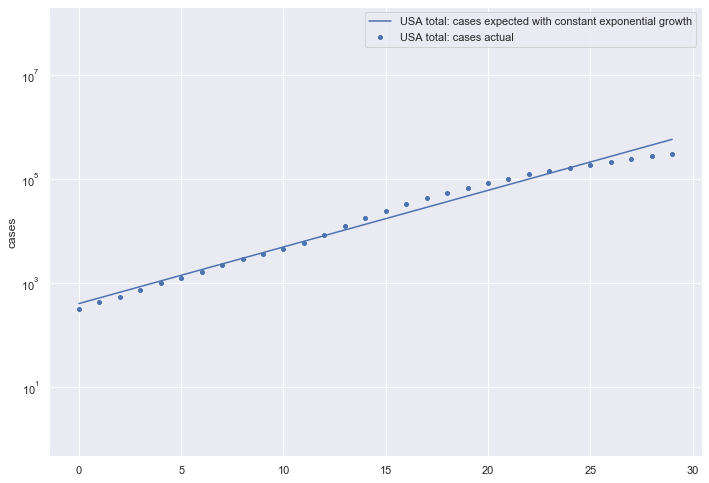

USA total: deaths exponential formula fitted with 30 points:
deaths = 11.68 * exp(0.2285 * day)
fitted daily growth rate: 25.68 %, fitted days to doubling: 3.03
actual daily growth rate: 19.28 %, actual days to doubling: 3.6


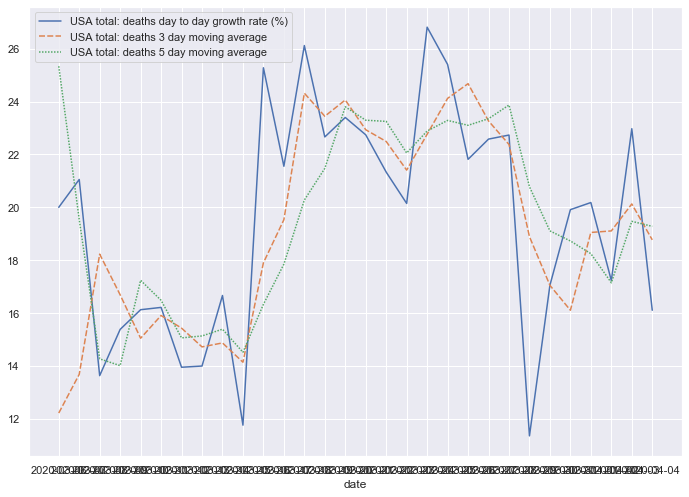

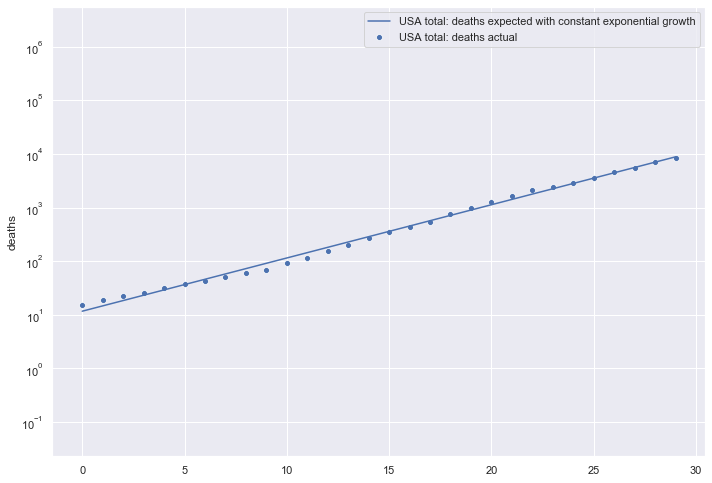

Trajectory plots for USA total:, to see when the curve starts flattening


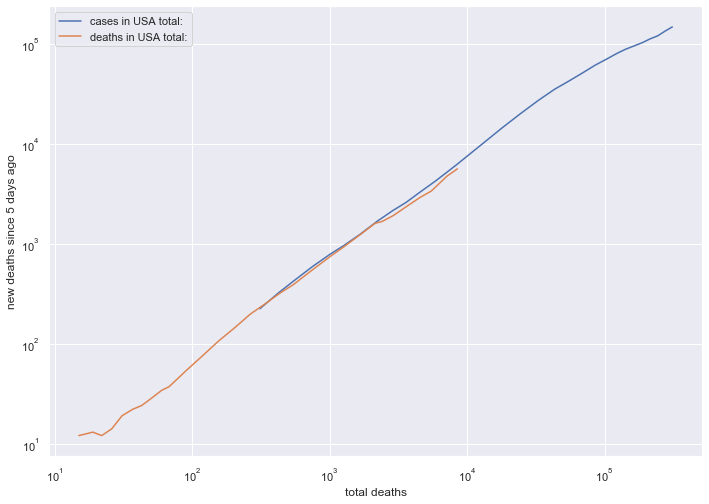

Correlations for USA total::


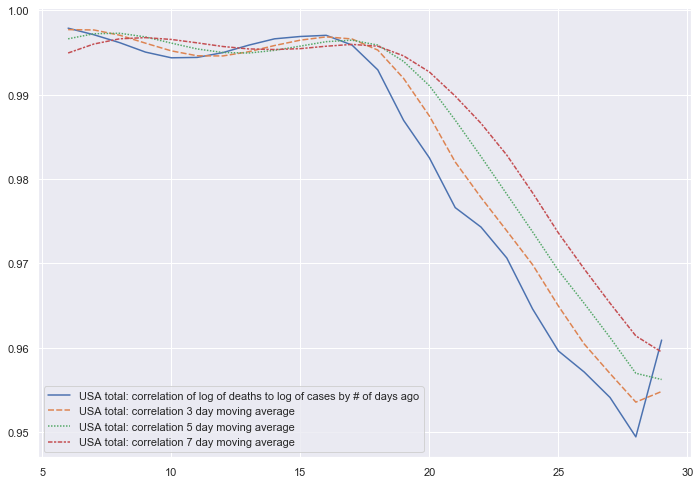

Deaths vs Lagged Values For USA total::


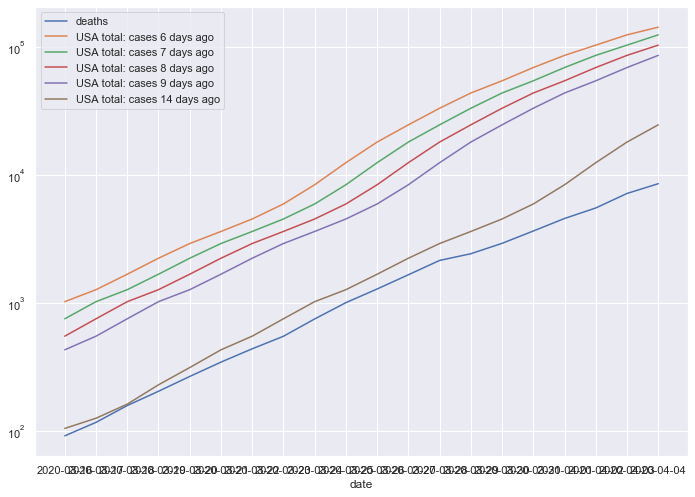

Deaths / Lagged Values For USA total::


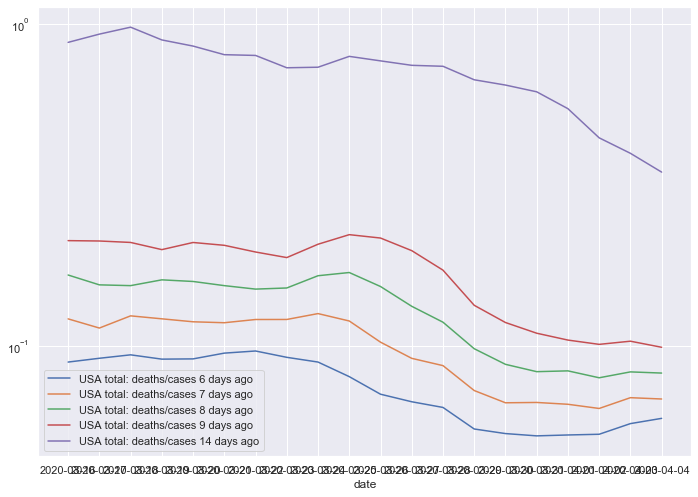

In [14]:
counties =["San Francisco", "Boulder", "Denver", "New York City"]
states = [ "California", "Colorado", "Arizona"]
analyse(counties=counties, states=states)

In [15]:
# counties with the most deaths today
today = rawData.tail(1).date.values[0]
rawData[rawData.date == today].groupby(['state', 'county']).sum().sort_values('deaths', ascending=False)

fips  cases  deaths
state         county                                
New York      New York City       0.0  63307    2254
              Nassau          36059.0  13346     396
              Unknown             0.0      0     309
Michigan      Wayne           26163.0   6762     252
Washington    King            53033.0   2900     204
New York      Westchester     36119.0  13080     197
New Jersey    Bergen          34003.0   5760     179
New York      Suffolk         36103.0  12328     175
Illinois      Cook            17031.0   7439     167
New Jersey    Essex           34013.0   3584     156
Louisiana     Orleans         22071.0   3966     153
Michigan      Oakland         26125.0   2785     142
California    Los Angeles      6037.0   5277     117
Louisiana     Jefferson       22051.0   3008      95
Connecticut   Fairfield        9001.0   2824      86
New Jersey    Hudson          34017.0   3491      78
Michigan      Macomb          26099.0   1838      78
New Jersey    Middlesex       34023.0   2578      76
New York      Rockland        36087.0   4872      69
New Jersey    Union           34039.0   2916      66
              Ocean           34029.0   2003      56
              Monmouth        34025.0   2065      54
New York      Orange          36071.0   2741      51
New Jersey    Morris          34027.0   1618      51
Washington    Snohomish       53061.0   1502      44
Nevada        Clark           32003.0   1418      41
California    Santa Clara      6085.0   1148      40
Massachusetts Middlesex       25017.0   2468      39
New Jersey    Passaic         34031.0   2856      38
Massachusetts Hampden         25013.0    733      35
...                               ...    ...     ...
Louisiana     Unknown             0.0     31       0
              Vernon          22115.0     11       0
              West Feliciana  22125.0     18       0
              Winn            22127.0      2       0
Massachusetts Dukes           25007.0      7       0
Maryland      Worcester       24047.0      7       0
              Washington      24043.0     29       0
              St. Mary's      24037.0     34       0
              Somerset        24039.0      4       0
              Queen Anne's    24035.0     13       0
              Kent            24029.0      5       0
              Harford         24025.0     44       0
              Garrett         24023.0      3       0
              Dorchester      24019.0      1       0
              Caroline        24011.0      4       0
              Allegany        24001.0      3       0
Maine         Washington      23029.0      1       0
              Waldo           23027.0      3       0
              Unknown             0.0     12       0
              Somerset        23025.0      3       0
              Sagadahoc       23023.0     13       0
              Penobscot       23019.0     22       0
              Oxford          23017.0     11       0
              Lincoln         23015.0      8       0
              Knox            23013.0      9       0
              Hancock         23009.0      2       0
              Franklin        23007.0      4       0
              Aroostook       23003.0      1       0
              Androscoggin    23001.0     20       0
Wyoming       Washakie        56043.0      2       0

[2409 rows x 3 columns]

In [16]:
# counties with the most cases today
rawData[rawData.date == today].groupby(['state', 'county']).sum().sort_values('deaths', ascending=False)

fips  cases  deaths
state         county                                
New York      New York City       0.0  63307    2254
              Nassau          36059.0  13346     396
              Unknown             0.0      0     309
Michigan      Wayne           26163.0   6762     252
Washington    King            53033.0   2900     204
New York      Westchester     36119.0  13080     197
New Jersey    Bergen          34003.0   5760     179
New York      Suffolk         36103.0  12328     175
Illinois      Cook            17031.0   7439     167
New Jersey    Essex           34013.0   3584     156
Louisiana     Orleans         22071.0   3966     153
Michigan      Oakland         26125.0   2785     142
California    Los Angeles      6037.0   5277     117
Louisiana     Jefferson       22051.0   3008      95
Connecticut   Fairfield        9001.0   2824      86
New Jersey    Hudson          34017.0   3491      78
Michigan      Macomb          26099.0   1838      78
New Jersey    Middlesex       34023.0   2578      76
New York      Rockland        36087.0   4872      69
New Jersey    Union           34039.0   2916      66
              Ocean           34029.0   2003      56
              Monmouth        34025.0   2065      54
New York      Orange          36071.0   2741      51
New Jersey    Morris          34027.0   1618      51
Washington    Snohomish       53061.0   1502      44
Nevada        Clark           32003.0   1418      41
California    Santa Clara      6085.0   1148      40
Massachusetts Middlesex       25017.0   2468      39
New Jersey    Passaic         34031.0   2856      38
Massachusetts Hampden         25013.0    733      35
...                               ...    ...     ...
Louisiana     Unknown             0.0     31       0
              Vernon          22115.0     11       0
              West Feliciana  22125.0     18       0
              Winn            22127.0      2       0
Massachusetts Dukes           25007.0      7       0
Maryland      Worcester       24047.0      7       0
              Washington      24043.0     29       0
              St. Mary's      24037.0     34       0
              Somerset        24039.0      4       0
              Queen Anne's    24035.0     13       0
              Kent            24029.0      5       0
              Harford         24025.0     44       0
              Garrett         24023.0      3       0
              Dorchester      24019.0      1       0
              Caroline        24011.0      4       0
              Allegany        24001.0      3       0
Maine         Washington      23029.0      1       0
              Waldo           23027.0      3       0
              Unknown             0.0     12       0
              Somerset        23025.0      3       0
              Sagadahoc       23023.0     13       0
              Penobscot       23019.0     22       0
              Oxford          23017.0     11       0
              Lincoln         23015.0      8       0
              Knox            23013.0      9       0
              Hancock         23009.0      2       0
              Franklin        23007.0      4       0
              Aroostook       23003.0      1       0
              Androscoggin    23001.0     20       0
Wyoming       Washakie        56043.0      2       0

[2409 rows x 3 columns]